# Image Prediction
We want to be able to perform predictions on arbitrary image sizes, but the network has specifically been trained to process 512x512 images. Passing larger images takes up a lot of memory, so I thought that one way to get around that would be to chop up the image into 512x512 pieces, after which each piece is passed through the network and merged together afterwards. The end result is a method that works on arbitrary image sizes. This notebook is primarily for testing that this functionality works as intended.

In [1]:
import os
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pickle


# Change to root path
if os.path.basename(os.getcwd()) != 'PConv-Keras':
    os.chdir('..')
import fig_utils as u
from libs.pconv_model import PConvUnet
from libs.util import MaskGenerator, ImageChunker

%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


# Load face images

In [2]:
# load original data
data_root_path = "tf_autozoom_2d_randVec20"
data_path = os.path.join("..", data_root_path, "all_test_results.pkl")
with open(data_path, "rb") as f:
    d = pickle.load(f)
df_test = d["df"]
true_test_x = d["true_x"]
true_test_y = d["true_y"]
adv_test_x = d["adv_x"]
diff_test_x = adv_test_x - true_test_x
orig_pred_test = d["orig_pred"]
adv_pred_test = d["adv_pred"]


# load corrupted data and region
with open(os.path.join("..", "corrupt_img", "test_corrupt_img.pkl"), "rb") as f:
    corrupted_test_x = pickle.load(f)
with open(os.path.join("..", "corrupt_img", "test_corrupt_region.pkl"), "rb") as f:
    corrupted_test_region = pickle.load(f)
with open(os.path.join("..", "corrupt_img", "test_rec_img.pkl"), "rb") as f:
    rec_test_x = pickle.load(f)

In [3]:
target_id = 6
target_img = true_test_x[:, target_id].reshape([32, 32]).T
target_corrupted_region = corrupted_test_region[target_id]
m = np.ones([32, 32], dtype=np.int32)
for (i, j) in target_corrupted_region:
    m[j, i] = 0

Sanity check

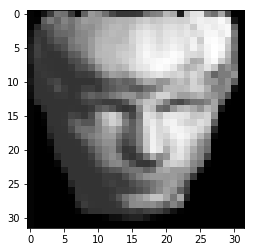

In [4]:
plt.imshow(target_img, cmap="gray")

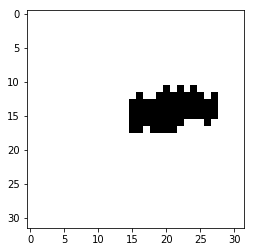

In [5]:
plt.imshow(m, cmap="gray")

In [6]:
img = Image.fromarray((target_img * 255).astype(np.uint8)).resize((512, 512))
mask = Image.fromarray((m * 255).astype(np.uint8)).resize((512, 512))

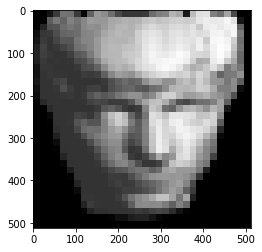

In [7]:
plt.imshow(img)

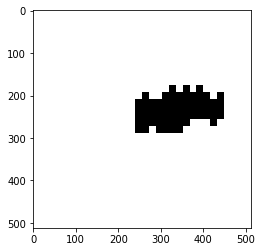

In [8]:
plt.imshow(mask)

In [9]:
# im = Image.open("out.png").resize((2048, 2048))

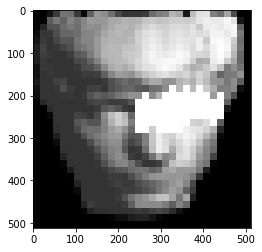

In [10]:
# convert back to np array
img = np.array(img)/255
mask = np.array(mask)/255
img[mask==0] = 1
plt.imshow(img, cmap="gray")

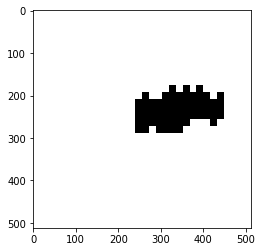

In [11]:
plt.imshow(mask, cmap="gray")

# Model Loading
We'll load the model trained on ImageNet

In [12]:
from libs.pconv_model import PConvUnet
model = PConvUnet(vgg_weights=None, inference_only=True)
# model.load(r"C:\Users\Mathias Felix Gruber\Documents\GitHub\PConv-Keras\data\logs\imagenet_phase2\weights.26-1.07.h5", train_bn=False)
model.load(os.path.join("data", "logs", "pconv_imagenet.26-1.07.h5"), train_bn=False)

# Prediction
When an image does not conform to the 512x512 restriction, the PConv model creates a batch of sub-images using the function `dimension_preprocess()`, which are then passed to the `predict()` method of the keras model. Subsequently, the predictions from the network as stitched together using `dimension_postprocess()` before being returned to the user. Let us first inspect the results from `dimension_preprocess()`.

Image with size: (512, 512, 3)


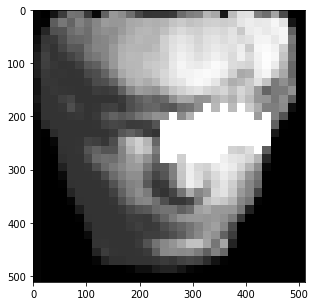

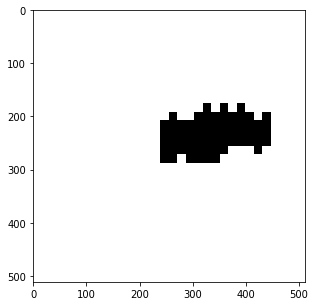

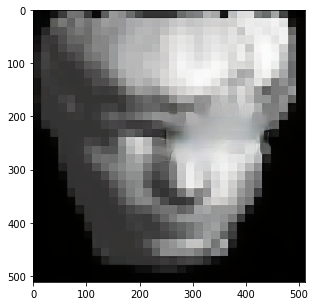

In [13]:
from libs.pconv_model import PConvUnet

# Used for chunking up images & stiching them back together
chunker = ImageChunker(512, 512, 30)

def plot_images(images, s=5):
    _, axes = plt.subplots(1, len(images), figsize=(s*len(images), s))
    if len(images) == 1:
        axes = [axes]
    for img, ax in zip(images, axes):
        ax.imshow(img)
    plt.show()
    
img = np.dstack((img, img, img))
mask = np.dstack((mask, mask, mask))
print("Image with size: {}".format(img.shape))

# Process sample
chunked_images = chunker.dimension_preprocess(deepcopy(img))
chunked_masks = chunker.dimension_preprocess(deepcopy(mask))

pred_imgs = model.predict([chunked_images, chunked_masks])
reconstructed_image = chunker.dimension_postprocess(pred_imgs, img)

# Plot results
plot_images(chunked_images)
plot_images(chunked_masks)
plot_images(pred_imgs)

# Code clean up

In [14]:
def prep_data(img):
    result = np.dstack((img, img, img))
    result = np.expand_dims(result, 0)
    return result
def img_rescale(img, target_dim):
    return np.array(Image.fromarray((img * 255).astype(np.uint8)).resize((target_dim, target_dim)))/255

In [15]:
target_id = 6
orig_img = true_test_x[:, target_id].reshape([32, 32]).T
corrupted_region = corrupted_test_region[target_id]
m = np.ones([32, 32], dtype=np.int32)
for (i, j) in corrupted_region:
    m[j, i] = 0

In [16]:
rescale_img = img_rescale(orig_img, 512)
rescale_mask = img_rescale(m, 512)
rescale_img[rescale_mask==0] = 1

rescale_img = prep_data(rescale_img)
rescale_mask = prep_data(rescale_mask)

In [17]:
pred_imgs = model.predict([rescale_img, rescale_mask])
pred_imgs = np.mean(pred_imgs[0, :, :, :], 2)

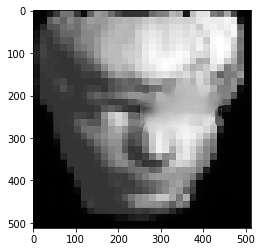

In [18]:
plt.imshow(pred_imgs, cmap="gray")